# Item Pricing Recommender

## RNN Pytorch Solution

## 1. Imports and installations needed

In [1]:
%matplotlib inline

import os
from pprint import pprint
import sys

import time
from time import gmtime, strftime

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import plotly.express as px

import sklearn.model_selection
from sklearn.metrics import mean_squared_log_error, mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

import seaborn as sns

import boto3
import sagemaker
from sagemaker import get_execution_role
from sagemaker.amazon.amazon_estimator import get_image_uri

In [2]:
!pip install textblob 
!pip install category_encoders

You should consider upgrading via the '/home/ec2-user/anaconda3/envs/pytorch_p36/bin/python -m pip install --upgrade pip' command.
You should consider upgrading via the '/home/ec2-user/anaconda3/envs/pytorch_p36/bin/python -m pip install --upgrade pip' command.


In [3]:
from textblob import TextBlob
from category_encoders import BinaryEncoder, OneHotEncoder

### We want to print full np.array and display all columns in a dataframe

In [4]:
np.set_printoptions(threshold=sys.maxsize)
pd.set_option('display.max_columns', None)

## 1. Download the data and define the functions needed to preprocess it

In [6]:
dframe=pd.read_csv('../data/train.tsv', sep='\t')

# As we did in the data exploration part, we expand the categories to their full hierarchy, one per column
dframe = dframe.join(dframe['category_name'].str.split('/', expand=True).add_prefix('cat_').fillna(np.nan))
dframe.head()

,train_id,name,item_condition_id,category_name,brand_name,price,shipping,item_description,cat_0,cat_1,cat_2,cat_3,cat_4
0,0,MLB Cincinnati Reds T Shirt Size XL,3,Men/Tops/T-shirts,NaN,10.0,1,No description yet,Men,Tops,T-shirts,NaN,NaN
1,1,Razer BlackWidow Chroma Keyboard,3,Electronics/Computers & Tablets/Components & P...,Razer,52.0,0,This keyboard is in great condition and works ...,Electronics,Computers & Tablets,Components & Parts,NaN,NaN
2,2,AVA-VIV Blouse,1,Women/Tops & Blouses/Blouse,Target,10.0,1,Adorable top with a hint of lace and a key hol...,Women,Tops & Blouses,Blouse,NaN,NaN
3,3,Leather Horse Statues,1,Home/Home Décor/Home Décor Accents,NaN,35.0,1,New with tags. Leather horses. Retail for [rm]...,Home,Home Décor,Home Décor Accents,NaN,NaN
4,4,24K GOLD plated rose,1,Women/Jewelry/Necklaces,NaN,44.0,0,Complete with certificate of authenticity,Women,Jewelry,Necklaces,NaN,NaN


In [7]:
def dropColumns(df, columns):
    """ Drops listed columns and returns the updated dataframe

    :param df: input dataframe
    :param columns: list of columns
    :return: processed dataframe
    """
    
    result =  all(elem in df.columns  for elem in columns)
    if result:
        df.drop(columns,axis=1,inplace=True)
        
    else:
        print('Some of the columns are not in the dataframe')
        
    return df

In [8]:
def dropMissingValues(df, columns):
    """ Drops rows with NaNs in the given columns and returns the updated dataframe
 
    :param df: input dataframe
    :param columns: list of columns
    :return: processed dataframe
    """
    
    df.dropna(subset=columns, inplace=True)
    
    return df

In [9]:
def replaceMissingValues(df, columns, value):
    """ Replaces NaNs with the given value in the given columns and returns the updated dataframe
 
    :param df: input dataframe
    :param columns: list of columns
    :param value: the replacement value
    :return: processed dataframe
    """
    for column in columns:
        df[column] = df[column].fillna(value)
    
    return df

In [10]:
def dropZeroPrice(df):
    """ Drops rows with price equal to 0 and returns updated dataframe
 
    :param df: input dataframe
    :return: processed dataframe
    """
    
    df = df[df.price>0]
    
    return df

In [11]:
def labelEncoding(df, columns):
    """ Encodes the given columns
 
    :param df: input dataframe
    :param columns: list of columns
    :return: processed dataframe
    """
    
    for column in columns:
        df[column + "_cat"] = df[column].astype('category').cat.codes
    return df

In [12]:
def sentimentAnalysis(df, columns):
    """ Computes the polarity of the sentiment of the given text columns
 
    :param df: input dataframe
    :param columns: list of columns
    :return: processed dataframe
    """
    
    for column in columns:
        df[column + '_tb'] = df[column].map(lambda ps: TextBlob(ps).sentiment.polarity)
    return df

In [13]:
def correlationPlot(df):
    """ Plots a correlation diagram.

    :param df: input dataframe
    :return: 
    """
    corr = df.corr()

    f,ax = plt.subplots(figsize=(19,16))
    sns.heatmap(corr, annot = True, linewidths=1.5 , fmt = '.2f',ax=ax)
    plt.show()

## 2. Preprocess data

In [14]:
dframe = dropColumns(df=dframe, columns=['category_name', 'cat_0', 'cat_1', 'cat_3', 'cat_4'])
dframe.head(5)

,train_id,name,item_condition_id,brand_name,price,shipping,item_description,cat_2
0,0,MLB Cincinnati Reds T Shirt Size XL,3,NaN,10.0,1,No description yet,T-shirts
1,1,Razer BlackWidow Chroma Keyboard,3,Razer,52.0,0,This keyboard is in great condition and works ...,Components & Parts
2,2,AVA-VIV Blouse,1,Target,10.0,1,Adorable top with a hint of lace and a key hol...,Blouse
3,3,Leather Horse Statues,1,NaN,35.0,1,New with tags. Leather horses. Retail for [rm]...,Home Décor Accents
4,4,24K GOLD plated rose,1,NaN,44.0,0,Complete with certificate of authenticity,Necklaces


In [15]:
print(dframe.columns[dframe.isnull().any()]) # Check again columns with nulls
now_cat_2_rows = dframe[dframe['cat_2'].isnull()].count()['train_id']
print(now_cat_2_rows) # Check number of rows with now cat_2

Index(['brand_name', 'item_description', 'cat_2'], dtype='object')
6327


In [16]:
# Drop the rows with now cat_2 (alternatively we could have included them in "Other")

initial = dframe.shape[0]
dframe = dropMissingValues(df=dframe, columns=['cat_2'])
assert(initial - dframe.shape[0]) == now_cat_2_rows

In [17]:
# Replace missing values in brand_name and item_description with empty

dframe = replaceMissingValues(dframe, ['brand_name', 'item_description'], '')
dframe.columns[dframe.isnull().any()]

Index([], dtype='object')

In [18]:
# Check items with price equal to 0, grouped by cat_2 and ordered in descendent order

dframe[dframe.price == 0].groupby(["cat_2"])["price"].count().sort_values(ascending=False)

cat_2
T-Shirts                   31
Shoes                      30
Other                      26
Face                       26
Pants, Tights, Leggings    25
                           ..
Household Cleaners          1
Ink & Toner                 1
Instrument Accessories      1
Writing                     1
Hair & Scalp Treatments     1
Name: price, Length: 198, dtype: int64

In [19]:
# We drop those items

dframe = dropZeroPrice(dframe)
dframe[dframe.price == 0].groupby(["cat_2"])["price"].count().sort_values(ascending=False)

Series([], Name: price, dtype: int64)

In [20]:
# More preprocessing, let's make sure again the type of each column

dframe.dtypes

train_id               int64
name                  object
item_condition_id      int64
brand_name            object
price                float64
shipping               int64
item_description      object
cat_2                 object
dtype: object

In [21]:
# And have a look of the content of our dataframe

dframe.head()

,train_id,name,item_condition_id,brand_name,price,shipping,item_description,cat_2
0,0,MLB Cincinnati Reds T Shirt Size XL,3,,10.0,1,No description yet,T-shirts
1,1,Razer BlackWidow Chroma Keyboard,3,Razer,52.0,0,This keyboard is in great condition and works ...,Components & Parts
2,2,AVA-VIV Blouse,1,Target,10.0,1,Adorable top with a hint of lace and a key hol...,Blouse
3,3,Leather Horse Statues,1,,35.0,1,New with tags. Leather horses. Retail for [rm]...,Home Décor Accents
4,4,24K GOLD plated rose,1,,44.0,0,Complete with certificate of authenticity,Necklaces


In [22]:
# Let's apply a binary encoder to the item_condition_id

enc = BinaryEncoder(cols=['cat_2', 'item_condition_id']).fit(dframe)
dframe = enc.transform(dframe)

dframe.head()

,train_id,name,item_condition_id_0,item_condition_id_1,item_condition_id_2,item_condition_id_3,brand_name,price,shipping,item_description,cat_2_0,cat_2_1,cat_2_2,cat_2_3,cat_2_4,cat_2_5,cat_2_6,cat_2_7,cat_2_8,cat_2_9,cat_2_10
0,0,MLB Cincinnati Reds T Shirt Size XL,0,0,0,1,,10.0,1,No description yet,0,0,0,0,0,0,0,0,0,0,1
1,1,Razer BlackWidow Chroma Keyboard,0,0,0,1,Razer,52.0,0,This keyboard is in great condition and works ...,0,0,0,0,0,0,0,0,0,1,0
2,2,AVA-VIV Blouse,0,0,1,0,Target,10.0,1,Adorable top with a hint of lace and a key hol...,0,0,0,0,0,0,0,0,0,1,1
3,3,Leather Horse Statues,0,0,1,0,,35.0,1,New with tags. Leather horses. Retail for [rm]...,0,0,0,0,0,0,0,0,1,0,0
4,4,24K GOLD plated rose,0,0,1,0,,44.0,0,Complete with certificate of authenticity,0,0,0,0,0,0,0,0,1,0,1


In [23]:
# and a one hot encoder to the shipping (we got only 0 or 1)

enc = OneHotEncoder(cols=['shipping']).fit(dframe)
dframe = enc.transform(dframe)

dframe.head()

,train_id,name,item_condition_id_0,item_condition_id_1,item_condition_id_2,item_condition_id_3,brand_name,price,shipping_1,shipping_2,item_description,cat_2_0,cat_2_1,cat_2_2,cat_2_3,cat_2_4,cat_2_5,cat_2_6,cat_2_7,cat_2_8,cat_2_9,cat_2_10
0,0,MLB Cincinnati Reds T Shirt Size XL,0,0,0,1,,10.0,1,0,No description yet,0,0,0,0,0,0,0,0,0,0,1
1,1,Razer BlackWidow Chroma Keyboard,0,0,0,1,Razer,52.0,0,1,This keyboard is in great condition and works ...,0,0,0,0,0,0,0,0,0,1,0
2,2,AVA-VIV Blouse,0,0,1,0,Target,10.0,1,0,Adorable top with a hint of lace and a key hol...,0,0,0,0,0,0,0,0,0,1,1
3,3,Leather Horse Statues,0,0,1,0,,35.0,1,0,New with tags. Leather horses. Retail for [rm]...,0,0,0,0,0,0,0,0,1,0,0
4,4,24K GOLD plated rose,0,0,1,0,,44.0,0,1,Complete with certificate of authenticity,0,0,0,0,0,0,0,0,1,0,1


In [24]:
dframe['item_description'] = dframe['item_description'].replace(['No description yet'],'') 

dframe.head(5)

,train_id,name,item_condition_id_0,item_condition_id_1,item_condition_id_2,item_condition_id_3,brand_name,price,shipping_1,shipping_2,item_description,cat_2_0,cat_2_1,cat_2_2,cat_2_3,cat_2_4,cat_2_5,cat_2_6,cat_2_7,cat_2_8,cat_2_9,cat_2_10
0,0,MLB Cincinnati Reds T Shirt Size XL,0,0,0,1,,10.0,1,0,,0,0,0,0,0,0,0,0,0,0,1
1,1,Razer BlackWidow Chroma Keyboard,0,0,0,1,Razer,52.0,0,1,This keyboard is in great condition and works ...,0,0,0,0,0,0,0,0,0,1,0
2,2,AVA-VIV Blouse,0,0,1,0,Target,10.0,1,0,Adorable top with a hint of lace and a key hol...,0,0,0,0,0,0,0,0,0,1,1
3,3,Leather Horse Statues,0,0,1,0,,35.0,1,0,New with tags. Leather horses. Retail for [rm]...,0,0,0,0,0,0,0,0,1,0,0
4,4,24K GOLD plated rose,0,0,1,0,,44.0,0,1,Complete with certificate of authenticity,0,0,0,0,0,0,0,0,1,0,1


In [25]:
# Binary encode the brand_name

brand_values = dframe.brand_name.unique().astype(str) # Let's see how many they are
print(len(brand_values))

enc = BinaryEncoder(cols=['brand_name']).fit(dframe)
dframe = enc.transform(dframe)

dframe.head()

4790


,train_id,name,item_condition_id_0,item_condition_id_1,item_condition_id_2,item_condition_id_3,brand_name_0,brand_name_1,brand_name_2,brand_name_3,brand_name_4,brand_name_5,brand_name_6,brand_name_7,brand_name_8,brand_name_9,brand_name_10,brand_name_11,brand_name_12,brand_name_13,price,shipping_1,shipping_2,item_description,cat_2_0,cat_2_1,cat_2_2,cat_2_3,cat_2_4,cat_2_5,cat_2_6,cat_2_7,cat_2_8,cat_2_9,cat_2_10
0,0,MLB Cincinnati Reds T Shirt Size XL,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,10.0,1,0,,0,0,0,0,0,0,0,0,0,0,1
1,1,Razer BlackWidow Chroma Keyboard,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,52.0,0,1,This keyboard is in great condition and works ...,0,0,0,0,0,0,0,0,0,1,0
2,2,AVA-VIV Blouse,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,10.0,1,0,Adorable top with a hint of lace and a key hol...,0,0,0,0,0,0,0,0,0,1,1
3,3,Leather Horse Statues,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,35.0,1,0,New with tags. Leather horses. Retail for [rm]...,0,0,0,0,0,0,0,0,1,0,0
4,4,24K GOLD plated rose,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,44.0,0,1,Complete with certificate of authenticity,0,0,0,0,0,0,0,0,1,0,1


In [26]:
# Finally, we compute the polarity of the sentiment analysis for item_description and name

dframe = sentimentAnalysis(dframe, ['item_description', 'name'])

dframe.head()

,train_id,name,item_condition_id_0,item_condition_id_1,item_condition_id_2,item_condition_id_3,brand_name_0,brand_name_1,brand_name_2,brand_name_3,brand_name_4,brand_name_5,brand_name_6,brand_name_7,brand_name_8,brand_name_9,brand_name_10,brand_name_11,brand_name_12,brand_name_13,price,shipping_1,shipping_2,item_description,cat_2_0,cat_2_1,cat_2_2,cat_2_3,cat_2_4,cat_2_5,cat_2_6,cat_2_7,cat_2_8,cat_2_9,cat_2_10,item_description_tb,name_tb
0,0,MLB Cincinnati Reds T Shirt Size XL,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,10.0,1,0,,0,0,0,0,0,0,0,0,0,0,1,0.000000,0.0
1,1,Razer BlackWidow Chroma Keyboard,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,52.0,0,1,This keyboard is in great condition and works ...,0,0,0,0,0,0,0,0,0,1,0,0.900000,0.0
2,2,AVA-VIV Blouse,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,10.0,1,0,Adorable top with a hint of lace and a key hol...,0,0,0,0,0,0,0,0,0,1,1,0.136250,0.0
3,3,Leather Horse Statues,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,35.0,1,0,New with tags. Leather horses. Retail for [rm]...,0,0,0,0,0,0,0,0,1,0,0,0.232121,0.0
4,4,24K GOLD plated rose,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,44.0,0,1,Complete with certificate of authenticity,0,0,0,0,0,0,0,0,1,0,1,0.100000,0.6


In [27]:
# We will deirve two more features, the lengths of name and item_description, on which we apply the standard scaler
# Finally, we dispose of name and item_description columns

dframe['name_len'] = dframe['name'].str.len()
dframe['item_description_len'] = dframe['item_description'].str.len()

scaler = StandardScaler()
dframe.name_len = scaler.fit_transform(dframe.name_len.to_numpy().reshape(-1, 1))
dframe.item_description_len = scaler.fit_transform(dframe.item_description_len.to_numpy().reshape(-1, 1))
dframe = dropColumns(dframe, ['name', 'item_description', 'train_id'])

dframe.head()

,item_condition_id_0,item_condition_id_1,item_condition_id_2,item_condition_id_3,brand_name_0,brand_name_1,brand_name_2,brand_name_3,brand_name_4,brand_name_5,brand_name_6,brand_name_7,brand_name_8,brand_name_9,brand_name_10,brand_name_11,brand_name_12,brand_name_13,price,shipping_1,shipping_2,cat_2_0,cat_2_1,cat_2_2,cat_2_3,cat_2_4,cat_2_5,cat_2_6,cat_2_7,cat_2_8,cat_2_9,cat_2_10,item_description_tb,name_tb,name_len,item_description_len
0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,10.0,1,0,0,0,0,0,0,0,0,0,0,0,1,0.000000,0.0,1.004765,-0.825897
1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,52.0,0,1,0,0,0,0,0,0,0,0,0,1,0,0.900000,0.0,0.677383,0.246388
2,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,10.0,1,0,0,0,0,0,0,0,0,0,0,1,1,0.136250,0.0,-1.286908,-0.118645
3,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,35.0,1,0,0,0,0,0,0,0,0,0,1,0,0,0.232121,0.0,-0.523017,0.160834
4,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,44.0,0,1,0,0,0,0,0,0,0,0,1,0,1,0.100000,0.6,-0.632144,-0.592048


In [28]:
dframe = dropColumns(dframe, ['brand_name'])

Some of the columns are not in the dataframe


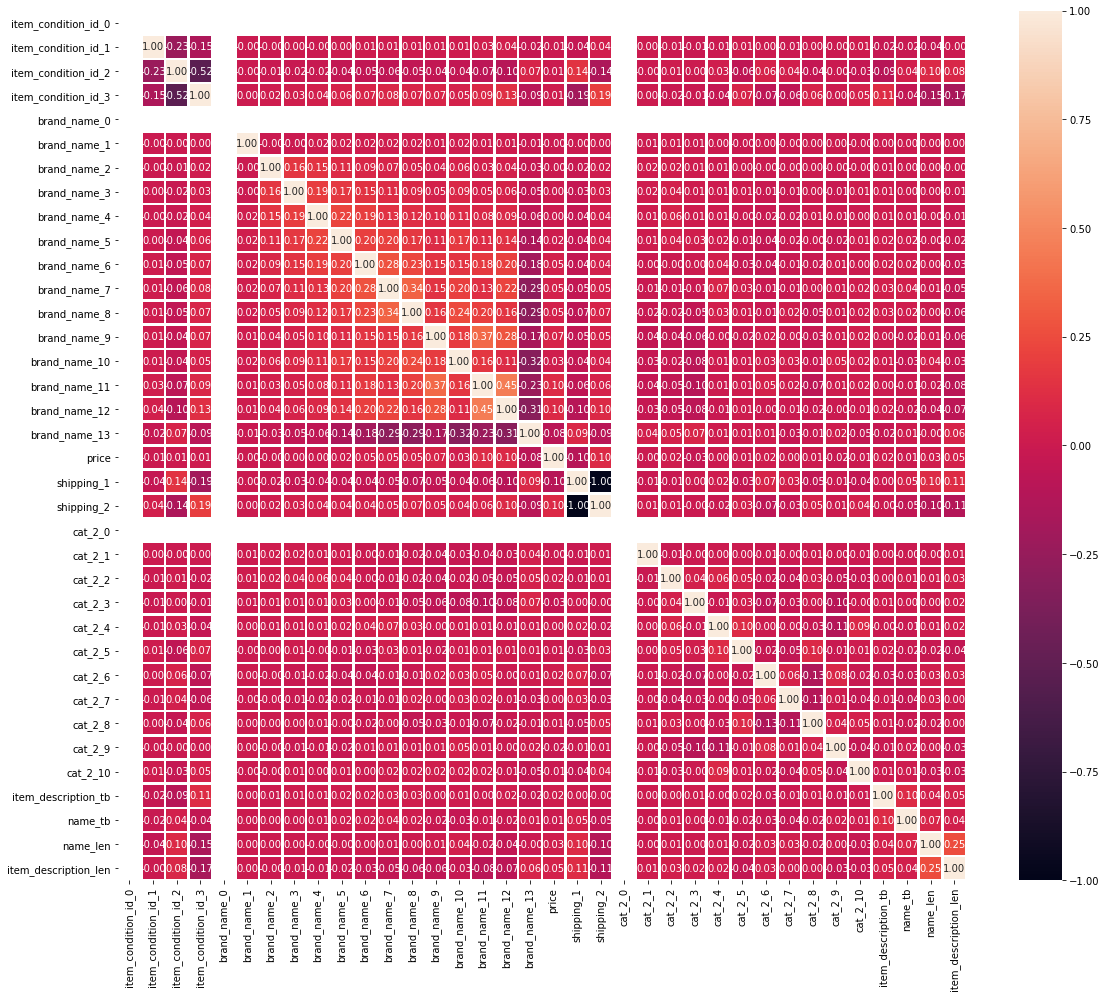

In [29]:
# Before proceeding with the XGBoost training, let's make sure parameter correlation is low

correlationPlot(dframe)

In [30]:
dframe.shape

(1475347, 36)

In [31]:
dframe.to_csv('./resources/dframe_saved.csv')

## 3. Prepare training, validation and test data

In [32]:
def splitData(df, test_size, y_column):
    """ Splits data in train and test.

    :param df: input dataframe
    :test_size: float
    :y_column: list of columns to be predicted
    :return: 4 dataframes
    """
    
    X_columns = [x for x in df.columns if x not in y_column]
    X_train, X_test, y_train, y_test = train_test_split(df[X_columns], df[y_column],
                                                        test_size=test_size)
    return X_train, X_test, y_train, y_test

In [33]:
X_train, X_test, y_train, y_test = splitData(df=dframe, test_size=0.2, y_column=['price'])

print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)

(1180277, 35) (1180277, 1) (295070, 35) (295070, 1)


In [34]:
def prepareCsv(x, y, filename, data_dir):
    '''Merges features and labels and converts them into one csv file with labels in the first column
    
       :param x: Data features
       :param y: Data labels
       :param file_name: Name of csv file, ex. 'train.csv'
       :param data_dir: The directory where files will be saved
       '''

    if not os.path.exists(data_dir):
        os.makedirs(data_dir)
    
    pd.concat([pd.DataFrame(y), pd.DataFrame(x)], axis=1).dropna() \
             .to_csv(os.path.join(data_dir, filename), header=False, index=False)
    
    print('File created: ' + str(data_dir) + '/' + str(filename))

In [35]:
# We generate the train and test data files 

resources_dir = 'resources'
prepareCsv(X_train, y_train, filename='train_nn.csv', data_dir=resources_dir)
prepareCsv(X_test, y_test, filename='test_nn.csv', data_dir=resources_dir)

File created: resources/train_nn.csv
File created: resources/test_nn.csv


## 4. Uploading the data files to S3

In [36]:
sagemaker_session = sagemaker.Session()
role = sagemaker.get_execution_role()

bucket = 'octa-capstone'
prefix = 'capstone-pytorch'

input_data = sagemaker_session.upload_data(path=resources_dir, bucket=bucket, key_prefix=prefix)

## 5. Defining a PyTorch Estimator

In [40]:
# Check the model.py code

!pygmentize resources/model.py

import torch.nn.functional as F
import torch.nn as nn


class Regression(nn.Module):
    """
    We define a neural network that performs linear regression.
    The network will accept the given features as input, and produce 
    a float value that is the price prediction.
    
    We use MSELoss to train the network
    """

    def __init__(self, input_features, hidden_dim1, hidden_dim2, output_dim):
        """
        We initialize the model by setting up linear layers.
        :param input_features: the number of input features in the training/test data
        :param hidden_dim1: helps define the number of nodes in the 1st hidden layer
        :param output_dim: the number of outputs we want to produce
        """
        super(Regression, self).__init__()

        self.fc1 = nn.Linear(input_features, hidden_dim1)
        self.fc2 = nn.Linear(hidden_dim1, hidden_dim2)
        self.fc3 = nn.Linear(hidden_dim2, output_dim)
        self.drop = nn.Dropout(0.3)

    
    def forward(

In [41]:
# Check the train.py code

!pygmentize resources/train.py

import argparse
import json
import os
import pandas as pd
import torch
import torch.optim as optim
import torch.utils.data
import torch.nn as nn

from model import Regression


def model_fn(model_dir):
    """
    Loads the PyTorch model from the `model_dir` directory.
    
    :param model_dir: model directory
    :return: model created
    """
    print("Loading model.")

    model_info = {}
    model_info_path = os.path.join(model_dir, 'model_info.pth')
    
    with open(model_info_path, 'rb') as f:
        model_info = torch.load(f)

    print("model_info: {}".format(model_info))

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = Regression(model_info['input_features'], model_info['hidden_dim1'], model_info['hidden_dim2'], model_info['output_dim'])

    model_path = os.path.join(model_dir, 'model.pth')
    with open(model_path, 'rb') as f:
        model.load_state_dict(torch.load(f))

    model.to(device).eval()

    print("Done loading model.")

In [42]:
from sagemaker.pytorch import PyTorch

output_path = 's3://{}/{}'.format(bucket, prefix)

estimator = PyTorch(entry_point='train.py',
                    source_dir=resources_dir,
                    role=role,
                    framework_version='1.0',
                    train_instance_count=1,
                    train_instance_type='ml.c4.4xlarge',
                    output_path=output_path,
                    sagemaker_session=sagemaker_session,
                    py_version='py3',
                    hyperparameters={
                        'input_features': 35,
                        'hidden_dim1': 128,
                        'hidden_dim2': 64,
                        'output_dim': 1,
                        'epochs': 20
                    })

train_instance_count has been renamed in sagemaker>=2.
See: https://sagemaker.readthedocs.io/en/stable/v2.html for details.
train_instance_type has been renamed in sagemaker>=2.
See: https://sagemaker.readthedocs.io/en/stable/v2.html for details.


In [43]:
%%time

# We train the estimator on the S3 training data

estimator.fit({'train': input_data})

2021-02-08 08:23:47 Starting - Starting the training job...
2021-02-08 08:24:11 Starting - Launching requested ML instancesProfilerReport-1612772494: InProgress
......
2021-02-08 08:25:12 Starting - Preparing the instances for training......
2021-02-08 08:26:13 Downloading - Downloading input data...
2021-02-08 08:26:44 Training - Downloading the training image..bash: cannot set terminal process group (-1): Inappropriate ioctl for device
bash: no job control in this shell
2021-02-08 08:26:59,136 sagemaker-containers INFO     Imported framework sagemaker_pytorch_container.training
2021-02-08 08:26:59,138 sagemaker-containers INFO     No GPUs detected (normal if no gpus installed)
2021-02-08 08:26:59,150 sagemaker_pytorch_container.training INFO     Block until all host DNS lookups succeed.
2021-02-08 08:26:59,151 sagemaker_pytorch_container.training INFO     Invoking user training script.

2021-02-08 08:27:13 Training - Training image download completed. Training in progress.2021-02-08 

## 6. Deploying the trained model

In [44]:
%%time

from sagemaker.pytorch import PyTorchModel

model = PyTorchModel(model_data=estimator.model_data,
                     role = role,
                     framework_version='1.0',
                     entry_point='predict.py',
                     py_version='py3',
                     source_dir=resources_dir)

# deploy your model to create a predictor
predictor = model.deploy(initial_instance_count=1, instance_type='ml.c4.xlarge')


-----------------------!CPU times: user 2min 13s, sys: 400 ms, total: 2min 14s
Wall time: 13min 48s


## 7. Evaluating the model

In [45]:
# Check the predict.py code

!pygmentize resources/predict.py

import os
import numpy as np
import torch
from six import BytesIO

from model import Regression


NP_CONTENT_TYPE = 'application/x-npy'


def model_fn(model_dir):
    """
    Loads the PyTorch model from the `model_dir` directory.
    
    :param model_dir: model directory
    :return: model created
    """
    print("Loading model.")

    model_info = {}
    model_info_path = os.path.join(model_dir, 'model_info.pth')
    with open(model_info_path, 'rb') as f:
        model_info = torch.load(f)

    print("model_info: {}".format(model_info))

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = Regression(model_info['input_features'], model_info['hidden_dim1'], model_info['hidden_dim2'], model_info['output_dim'])

    model_path = os.path.join(model_dir, 'model.pth')
    with open(model_path, 'rb') as f:
        model.load_state_dict(torch.load(f))

    model.to(device).eval()

    print("Done loading model.")
    return model


def input_fn(serialized_

In [2]:
test_data = pd.read_csv(os.path.join(resources_dir, "test_nn.csv"), header=None, names=None)

test_y = test_data.iloc[:,0]
test_x = test_data.iloc[:,1:]
del test_data

In [3]:
sagemaker_session = sagemaker.Session()
role = sagemaker.get_execution_role()

bucket = 'octa-capstone'
prefix = 'capstone-pytorch'
predictor = sagemaker.predictor.Predictor("sagemaker-pytorch-2021-02-08-09-15-48-675", sagemaker_session, \
                                          sagemaker.serializers.NumpySerializer(), \
                                          sagemaker.deserializers.NumpyDeserializer())

In [4]:
# We call the predictor in batches of 50000, to avoid timeouts

test_elements = test_x.shape[0]
test_y_preds = []

for i in range(test_elements//50000 + 1):
    new_predictions = predictor.predict(test_x.loc[i*50000:min((i+1)*50000-1,test_elements-1)])
    test_y_preds.extend(new_predictions)
    
assert(len(test_y_preds)) == test_elements

In [5]:
del test_x

In [6]:
def rmse(y_test, y_pred): 
    """ Computes RMSE

    :param y_test: y test
    :param y_pred: y predicted
    :return: RMSE value
    """
    return np.sqrt(np.mean(np.square(np.array(y_pred, dtype=np.int16) - np.array(y_test.to_numpy(), dtype=np.int16))))

In [7]:
def rmsle(y_test, y_pred): 
    """ Computes RMSLE

    :param y_test: y test
    :param y_pred: y predicted
    :return: RMSLE value
    """
    return np.sqrt(np.mean(np.square(np.log(np.array(y_pred, dtype=np.int16) + 1) - np.log(np.array(y_test.to_numpy(), dtype=np.int16) + 1))))


In [20]:
def mape(y_test, y_pred): 
    """ Computes MAPE

    :param y_test: y test
    :param y_pred: y predicted
    :return: MAPE value
    """
    return np.mean(np.abs((np.array(y_test.to_numpy(), dtype=np.int16) - np.array(y_pred, dtype=np.int16)) / np.array(y_test.to_numpy(), dtype=np.int16)))


In [14]:
def mae(y_test, y_pred): 
    """ Computes MAE

    :param y_test: y test
    :param y_pred: y predicted
    :return: MAE value
    """
    return np.mean(np.abs(np.array(y_test.to_numpy(), dtype=np.int16) - np.array(y_pred, dtype=np.int16)))


In [7]:
print("RMSE = {}".format(rmse(test_y, test_y_preds)))

RMSE = 27.18863965354332


In [13]:
print('RMSLE = {}'.format(rmsle(test_y, test_y_preds)))

RMSLE = 0.8581451773643494


In [23]:
print('MAPE = {}'.format(mape(test_y, test_y_preds)))

MAPE = 1.0561008314855789


In [15]:
print('MAE = {}'.format(mae(test_y, test_y_preds)))

MAE = 19.6236273608


Text(0.5, 1.0, 'Predicted Price vs Test Price')

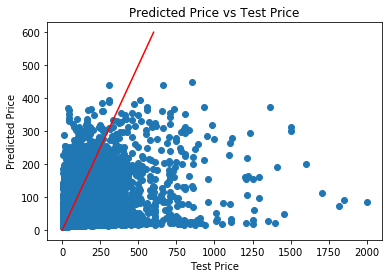

In [24]:
plt.scatter(pd.DataFrame(test_y), pd.DataFrame(test_y_preds))
plt.plot([0, 600], [0, 600], 'r-')
plt.xlabel("Test Price")
plt.ylabel("Predicted Price")
plt.title("Predicted Price vs Test Price")

## 8. Clean up

In [ ]:
boto3.client('sagemaker').delete_endpoint(EndpointName=predictor.endpoint)


In [ ]:
# Remove all local files and directory

!rm $resources_dir/*.csv